In [ ]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 120)

DATA_PATH = "../../data/raw_data/raw_spotify_song_info.csv.csv"
EXPORT_DIR = "./artifacts"
os.makedirs(EXPORT_DIR, exist_ok=True)

Data Interpretation

In [ ]:
df = pd.read_csv(DATA_PATH)
print("Rows, Cols:", df.shape)
display(df.head(5))
df.info()

Numeric Set

In [ ]:
numeric_cols = df.select_dtypes(include = [np.number]).columns.tolist()

Correlation Matrix

In [ ]:
corr = df[numeric_cols].corr(numeric_only = True)
corr

plt.figure(figsize=(12, 8))
plt.imshow(corr, aspect = 'auto')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation = 90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Feature Distribution & Skewness

In [ ]:
for c in numeric_cols:
    plt.figure(figsize=(6,4))
    df[c].dropna().plot(kind="hist", bins=40)
    plt.title(f"Distribution: {c}")
    plt.xlabel(c)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

sk = df[numeric_cols].skew(numeric_only=True)
display(sk.sort_values(ascending=False).to_frame("skew"))

Popular VS non-popular

In [ ]:
 popularity_threshold = 75
 df["popular_flag"] = (df["popularity"] >= popularity_threshold).astype(int)

 for c in numeric_cols:
    if c != "popularity":
        summary = df.groupby("popular_flag")[c].agg(["mean","median","std"]).reset_index()
        display(summary.style.set_caption(f"Summary of {c} by Popularity Flag"))

Fingerprint

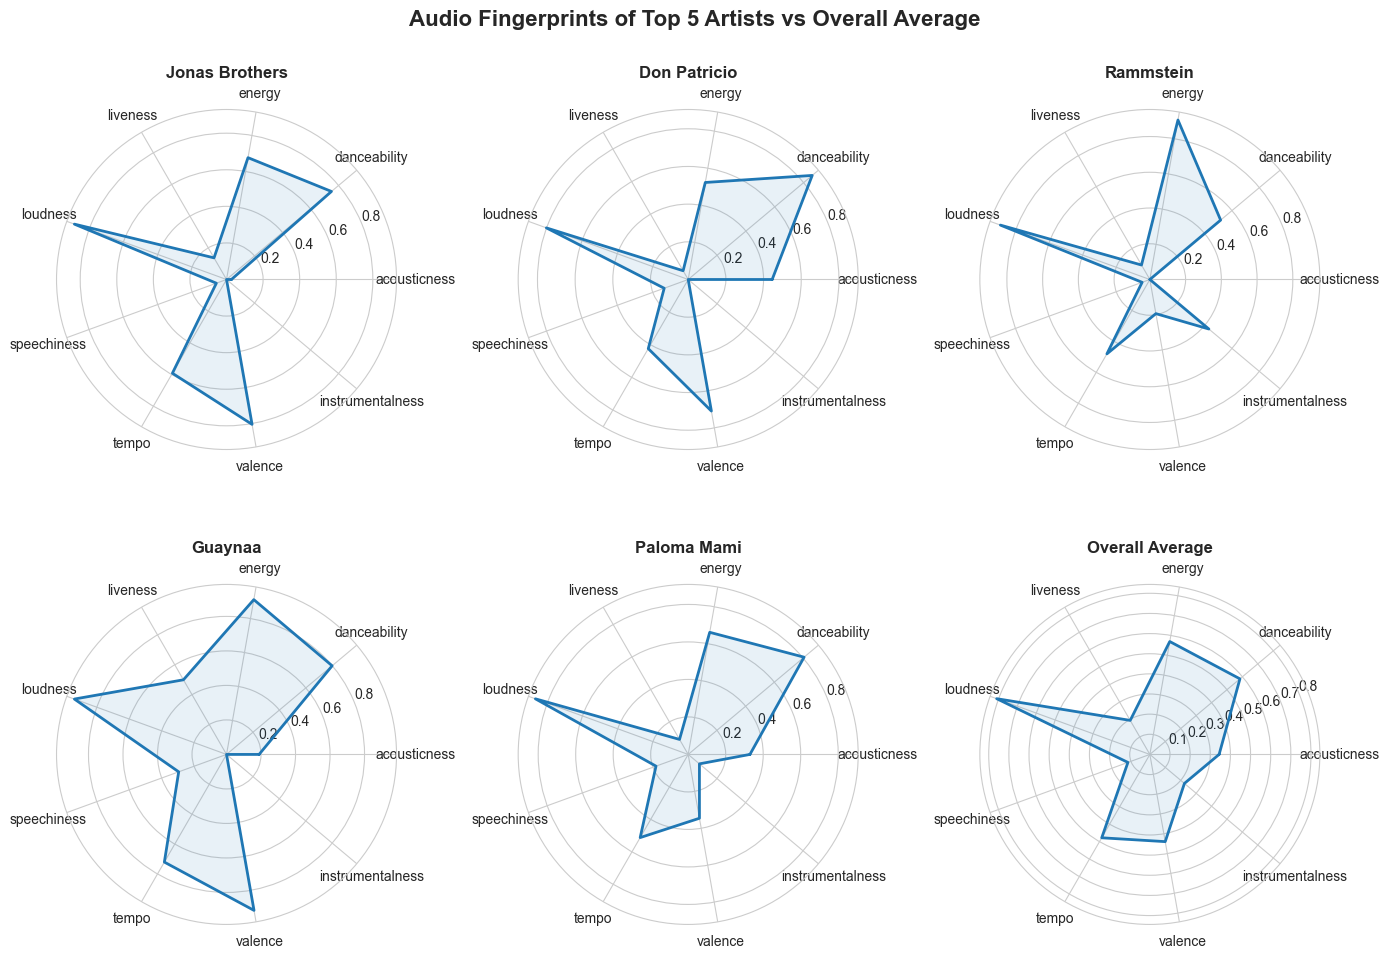

In [15]:
target_artist = "Drake"  # e.g., "Taylor Swift"
artist_col = "artist_name" if "artist_name" in df.columns else None
fingerprint_cols = [c for c in [
    "acousticness","danceability","energy","liveness","loudness",
    "speechiness","tempo","valence","instrumentalness"
] if c in df.columns]

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[fingerprint_cols] = scaler.fit_transform(df_scaled[fingerprint_cols])

top_artists = (
    df.groupby(artist_col)["popularity"]
      .mean()
      .sort_values(ascending=False)
      .head(5)
      .index.tolist()
)
artist_groups = top_artists + ["Overall Average"]
plt.figure(figsize=(14, 10))

for i, artist in enumerate(artist_groups, 1):
    if artist != "Overall Average":
        subset = df_scaled[df[artist_col] == artist][fingerprint_cols]
    else:
        subset = df_scaled[fingerprint_cols]  # global average

    vec = subset.mean().values.astype(float)
    labels = fingerprint_cols
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    vec = np.concatenate([vec, vec[:1]])
    angles = np.concatenate([angles, angles[:1]])

    ax = plt.subplot(2, 3, i, polar=True)
    ax.plot(angles, vec, linewidth=2)
    ax.fill(angles, vec, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f"{artist}", size=12, weight='bold')

plt.suptitle("Audio Fingerprints of Top 5 Artists vs Overall Average", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

Popularity drivers

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_cols = [c for c in numeric_cols if c != "popularity"]
X = df[X_cols].select_dtypes(include = [np.number]).fillna(0)
y = df["popularity"].fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators = 250, random_state=42, n_jobs = -1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("R2:", round(r2_score(y_test, preds), 4), "MAE:", round(mean_absolute_error(y_test, preds), 3))

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.to_frame("importance"))

plt.figure(figsize = (12, 8))
importances.head(15).sort_values().plot(kind = "barh")
plt.title("Top feature importances (Random Forest)")
plt.tight_layout()
plt.show()

Unsupervised clustering

Silhouette score: 0.127


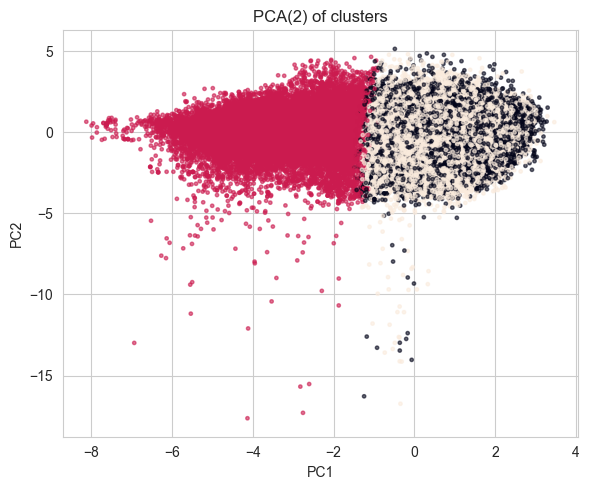

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_features = [c for c in numeric_cols if c != "popularity"]
Xc = df[cluster_features].select_dtypes(include=[np.number]).dropna()
if len(Xc) > 0 and Xc.shape[1] >= 2:
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xc)

    k = 3
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    sil = silhouette_score(Xs, labels)
    print("Silhouette score:", round(sil, 3))

    X2 = PCA(n_components=2, random_state=42).fit_transform(Xs)
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], s=6, alpha=0.6, c=labels)
    plt.title("PCA(2) of clusters")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

A/B testing simulation

In [10]:
df_ab = df.copy()
df_ab["baseline_score"] = df_ab["popularity"]
if {"energy", "danceability"}.issubset(df_ab.columns):
    df_ab["variant_score"] = 0.7*df_ab["popularity"] + 0.15*df_ab["energy"] + 0.15*df_ab["danceability"]
else:
    df_ab["variant_score"] = df_ab["popularity"]

N = 50
base_top = df_ab.nlargest(N, "baseline_score")
var_top  = df_ab.nlargest(N, "variant_score")
overlap = len(set(base_top.index) & set(var_top.index)) / N
print(f"Top-{N} overlap between baseline and variant: {overlap:.2f}")

Top-50 overlap between baseline and variant: 0.90


Export